In [0]:
# This Notebook creates a Machine Learning model that, given a player's 
# regular-season statistics, predicts whether or not that season results in an
# All-Star appearance.

# I referred to the following Notebook from Google's Machine Learning course 
# while creating this.
# https://colab.research.google.com/notebooks/mlcc/feature_sets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=featuresets-colab&hl=en#scrollTo=SrOYRILAH3pJ

#%% Setup
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#%% Import Data
FILE_NAME = root_path + "all_player_stats.csv"
data = pd.read_csv(FILE_NAME, sep=",")


#%% Eliminates partial seasons that result from trades, leaving only the total season stats
def eliminate_duplicate_seasons(seasons):
    to_remove = []
    for i in range(len(seasons)):
        if (seasons["SEASON_ID"].iloc[i] == seasons["SEASON_ID"].iloc[i-1]) \
                and (seasons["PLAYER_ID"].iloc[i] == seasons["PLAYER_ID"].iloc[i-1]):
            to_remove.append(i-1)
    seasons.drop(seasons.index[to_remove], axis=0, inplace=True)

eliminate_duplicate_seasons(data)
data.drop(columns=["PLAYER_ID", "LEAGUE_ID", "TEAM_ID", "TEAM_ABBREVIATION"], inplace=True)
# for i in range(0, len(data["PLAYER_AGE"])):
#     data["PLAYER_AGE"] = data["PLAYER_AGE"].astype('int')
data = data.fillna(0)
data.describe()

,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,ALL_STAR
count,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000,21813.000000
mean,27.035621,55.649979,20.048870,1294.569935,216.615688,478.477559,0.431129,20.170403,57.488012,0.161328,113.247100,151.193325,0.701505,57.380965,138.068766,242.794068,126.792234,37.020722,22.885389,64.608536,127.510613,566.648879,0.072113
std,4.225182,24.904332,28.342677,957.979647,192.230446,405.382797,0.095172,39.109054,104.352980,0.183419,116.933284,150.246975,0.177262,68.492650,150.921116,235.025146,140.937901,39.829523,36.780061,70.008019,83.877650,504.803369,0.258681
min,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,38.000000,0.000000,390.000000,56.000000,136.000000,0.394000,0.000000,0.000000,0.000000,24.000000,36.000000,0.650000,4.000000,11.000000,62.000000,25.000000,3.000000,1.000000,2.000000,54.000000,147.000000,0.000000
50%,26.000000,64.000000,2.000000,1226.000000,170.000000,388.000000,0.440000,0.000000,4.000000,0.000000,76.000000,106.000000,0.739000,32.000000,95.000000,183.000000,81.000000,25.000000,9.000000,43.000000,126.000000,444.000000,0.000000
75%,30.000000,77.000000,36.000000,2086.000000,328.000000,728.000000,0.481000,20.000000,64.000000,0.333000,165.000000,222.000000,0.805000,86.000000,210.000000,346.000000,179.000000,59.000000,28.000000,106.000000,192.000000,856.000000,0.000000
max,94.000000,88.000000,83.000000,3882.000000,1597.000000,3159.000000,1.000000,402.000000,1028.000000,1.000000,840.000000,1363.000000,1.000000,587.000000,1111.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000,1.000000


In [0]:
#%% Preprocess
def preprocess_features(df):
    features = df.drop(["ALL_STAR"], axis=1, inplace=False)
    return features


def preprocess_targets(df):
    targets = pd.DataFrame()
    targets["ALL_STAR"] = df["ALL_STAR"]
    return targets

# Split Training/Testing
# Shuffle
data = data.sample(frac=1).reset_index(drop=True)
training_amount = round(len(data)*.8)

# Training
training_examples = preprocess_features(data.head(training_amount))
training_targets = preprocess_targets(data.head(training_amount))

# Testing
validation_examples = preprocess_features(data.tail(len(data) - training_amount))
validation_targets = preprocess_targets(data.tail(len(data) - training_amount))

In [0]:
#%% Create Feature Columns
def create_feature_columns(features):
    my_feature = features["SEASON_ID"]
    feature_columns = [tf.feature_column.categorical_column_with_hash_bucket("SEASON_ID", hash_bucket_size=25)]

    # my_feature = features["PLAYER_AGE"]
    # feature_columns.append(tf.feature_column.categorical_column_with_hash_bucket("PLAYER_AGE", hash_bucket_size=25))

    for i in range(2, len(features.columns.values) - 1):
        column_name = features.columns.values[i]
        my_feature = features[column_name]
        feature_columns.append(tf.feature_column.numeric_column(column_name))
    return feature_columns

In [0]:
#%% Input Function
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)

    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
#%% Train Model
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods

    # linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=create_feature_columns(training_examples), optimizer=my_optimizer)

    # input functions
    training_input_fn = lambda: my_input_fn(training_examples, training_targets["ALL_STAR"], batch_size=batch_size)

    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["ALL_STAR"], num_epochs=1, shuffle=False)

    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["ALL_STAR"], num_epochs=1, shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("Log Error (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_log_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_log_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_log_error)
        validation_rmse.append(validation_log_error)
        
        
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Log Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor


W0627 12:07:04.053134 139659732227968 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpdift1soj


Training model...
Log Error (on training data):
  period 00 : 0.27
  period 01 : 0.27
  period 02 : 0.25
  period 03 : 0.27
  period 04 : 0.27
  period 05 : 0.27
  period 06 : 0.27
  period 07 : 0.26
  period 08 : 0.26
  period 09 : 0.26
Model training finished.


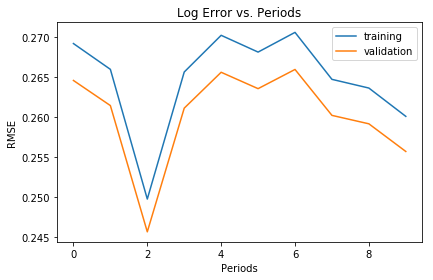

In [0]:
#%% Train
train_model(
    learning_rate=0.000001,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)